In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import collections
from tqdm import tqdm

import seaborn as sns
import torch
from torch import nn

import sklearn
import sklearn.metrics

sns.set_style('whitegrid')


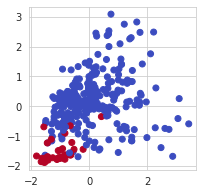

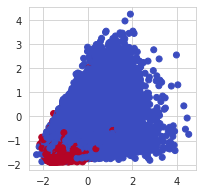

In [2]:
# ----------------------- Data loading and preprocessig ---------------------- #

file_train = 'ZipDigits.train'
file_test = 'ZipDigits.test'


def read_data(file_name):
    digits = []
    images = []
    with open(file_name, 'r') as f:
        for line in f:
            line = line.strip().split(' ')
            line = [float(i) for i in line]
            digit = int(line[0])
            data = line[1:]
            images.append(data)
            digits.append(digit)
    return np.array(images), np.array(digits)


def get_features(file_name):
    images, digits = read_data(file_name)
    images = images.reshape(-1, 16, 16)
    images = (images + 1) / 2  # normalize between [0,1]

    # index = (digits == 1) | (digits == 5)
    # images = images[index]
    # digits = digits[index]

    # Extract feature
    intensities = images.reshape(-1, 16 * 16).mean(axis=-1)
    symmetry = np.power(images[..., ::-1] - images,
                        2).reshape(images.shape[0], -1).mean(axis=-1)

    ind_1 = (digits == 1)
    # ind_5 = (digits == 5)
    ind_5 = (digits != 1)
    labels = np.zeros(digits.shape[0])
    labels[ind_1] = 1
    labels[ind_5] = -1
    features = np.concatenate((intensities[:, None], symmetry[:, None]),
                              axis=1)
    return features, labels


# ------------------------------ train features ------------------------------ #
features_train, labels_train = get_features(file_train)

# ------------------------------- test features ------------------------------ #
features_test, labels_test = get_features(file_test)

# ----------------------------- combine the data ----------------------------- #
features = np.concatenate((features_train, features_test), axis=0)
labels = np.concatenate((labels_train, labels_test), axis=0)

# normalize features
import sklearn.preprocessing as preprocessing

features = preprocessing.MinMaxScaler(
    feature_range=(-1, 1)).fit_transform(features)

# split test and train
from sklearn.model_selection import train_test_split

features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, train_size=300, random_state=78)

# standardize features
standardizer = preprocessing.StandardScaler().fit(features_train)
features_train = standardizer.fit_transform(features_train)
features_test = standardizer.transform(features_test)

# plot features and labels
plt.figure(figsize=(3, 3))
plt.scatter(features_train[:, 0],
            features_train[:, 1],
            c=labels_train,
            cmap='coolwarm')
plt.figure(figsize=(3, 3))
plt.scatter(features_test[:, 0],
            features_test[:, 1],
            c=labels_test,
            cmap='coolwarm')


In [48]:
from matplotlib.colors import ListedColormap


def plot_decision_boundary(clf, features_train, labels_train, title='decision boundary', **kwargs):
    cmap_light = ListedColormap(["orange", "green"])
    cmap_dark = ListedColormap(["darkorange", "darkgreen"])

    xx, yy = np.meshgrid(np.arange(-2, 2, 0.02), np.arange(-2, 2, 0.02))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()], **kwargs)
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=cmap_light)
    plt.scatter(features_train[:, 0],
                features_train[:, 1],
                c=labels_train,
                s=30,
                cmap=cmap_dark,
                edgecolors="black")
    plt.title(title)

test accuracy for C:0.0001 : 0.9519
test accuracy for C:1000.0 : 0.9228


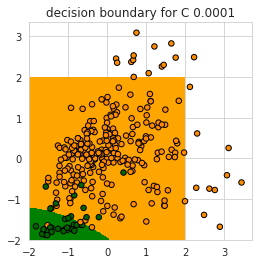

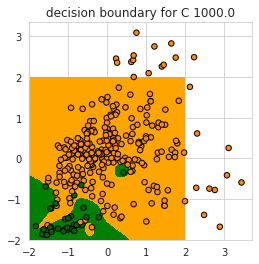

In [49]:
from sklearn.svm import SVC

C_low = 1e-4
clf = SVC(C=C_low, kernel='poly', degree=8, gamma='auto', coef0=1)
clf.fit(features_train, labels_train)
preds = clf.predict(features_test)
accuracy = sklearn.metrics.accuracy_score(labels_test, preds)
print(f'test accuracy for C:{C_low} : {accuracy:.4f}')

plt.figure(figsize=(4, 4))
plot_decision_boundary(clf,
                       features_train,
                       labels_train,
                       title=f'decision boundary for C {C_low}')

C_high = 1e3
clf = SVC(C=C_high, kernel='poly', degree=8, gamma='auto', coef0=1)
clf.fit(features_train, labels_train)
preds = clf.predict(features_test)
accuracy = sklearn.metrics.accuracy_score(labels_test, preds)
print(f'test accuracy for C:{C_high} : {accuracy:.4f}')

plt.figure(figsize=(4, 4))
plot_decision_boundary(clf,
                       features_train,
                       labels_train,
                       title=f'decision boundary for C {C_high}')


100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

best C: 0.01 with score :0.9567
test accuracy for C:1000.0 : 0.9550


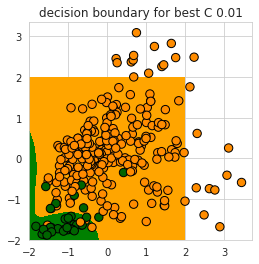

In [46]:
# ------------------------ Cross validation to chose C ----------------------- #
from sklearn.model_selection import cross_val_score

params_C = np.logspace(-4, 3, num=8)
scores = []

for C in tqdm(params_C):
    clf = SVC(C=C, kernel='poly', degree=8, gamma='auto', coef0=1)
    cv_score = cross_val_score(clf, features_train, labels_train, cv=5)
    scores.append(cv_score.mean())

# best C
best_C = params_C[np.argmax(scores)]
print(f'best C: {best_C} with score :{np.max(scores):.4f}')


clf_best = SVC(C=best_C, kernel='poly', degree=8, gamma='auto', coef0=1)
clf_best.fit(features_train, labels_train)
preds = clf_best.predict(features_test)
accuracy = sklearn.metrics.accuracy_score(labels_test, preds)
print(f'test accuracy for C:{C_high} : {accuracy:.4f}')

plt.figure(figsize=(4, 4))
plot_decision_boundary(clf_best,
                       features_train,
                       labels_train,
                       title=f'decision boundary for best C {best_C}')